In [1]:
import os
from igor import binarywave
import matplotlib.pyplot as plt
import h5py
from numpy import flipud
import numpy as np
import glob

from PIL import Image



In [2]:
#Find list of .IBW files in current working directory, and all sub-directories

import pathlib

full_file_list = []
# Get the current working directory
current_directory = pathlib.Path('.')

# Recursively traverse all files in the current directory and its subdirectories
for file_path in current_directory.rglob('*'):  # rglob('*') matches all files and folders
    if file_path.is_file():  # Check if it's a file (not a directory)
        if str(file_path)[-4:] == '.ibw':
            full_file_list.append(str(file_path))
            
print(full_file_list)

['SD_P4_zA2_050mV_0000.ibw']


In [3]:

def correct_label(label):
    label = [x for x in label if x]  # Remove the empty lists
    label = label[0]  # Remove the unnecessary inception

    corrected_label = []

    for i in label:
        i = i.decode('UTF-8')
        if len(i) == 0:  # Skip empty channel names
            pass
        else:  # Correct the duplicate letters
            if 'Trace' in i:
                i = i.split('Trace')[0]
                corrected_label.append(i + 'Trace')
            elif 'Retrace' in i:
                i = i.split('Retrace')[0]
                corrected_label.append(i + 'Retrace')
            else:
                corrected_label.append(i)
    corrected_label = [x.encode() for x in corrected_label]
    return corrected_label

In [4]:
#Create new folders if necessary

from pathlib import Path

# Get the current working directory
current_directory = Path.cwd()

for folder_name in ["Raw_Data", "Composed_Data"]:
    # Define the relative folder path
    folder_path = current_directory / folder_name

    # Create the folder if it doesn't exist
    folder_path.mkdir(parents=True, exist_ok=True)

SD_P4_zA2_050mV_0000.ibw
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


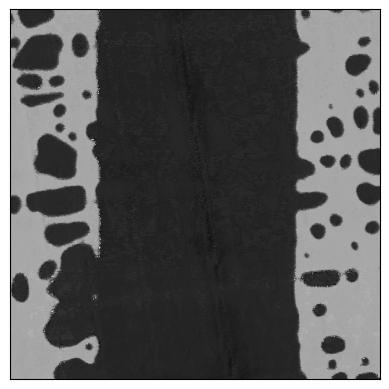

In [5]:
#check if .ibw was gathered in PFM mode, and if it was done in DART. If so, saves Amplitude2Retrace, Phase2Retrace, and Height.

for filename in sorted(full_file_list)[:]:
    print(filename)
    tmpdata = binarywave.load(filename)['wave']
    note = tmpdata['note']

    #print(str(note))
    if 'ImagingMode:PFM Mode' in str(note):
        #print(note)
        #input()
        label_list = correct_label(tmpdata['labels'])
        try:
            scale =  float(str(tmpdata['note']).split('FastScanSize:')[-1].split('\\r')[0])/tmpdata['wData'][:, :, 0].T.shape[0]
        except:
            continue
        fastsize = float(str(note).split('FastScanSize:')[-1].split('\\r')[0])
        slowsize = float(str(note).split('SlowScanSize:')[-1].split('\\r')[0])
        xoffset = float(str(note).split('XOffset:')[1].split('\\r')[0])
        yoffset = float(str(note).split('YOffset:')[1].split('\\r')[0])

        if (b'HeightRetrace' in label_list) and (b'Phase2Retrace' in label_list):

            for i, k in enumerate(label_list):
                data=flipud(tmpdata['wData'][:,:, i].T)
                print(np.shape(data))
                shape = tmpdata['wData'][:, i].T.shape
                scale_m_per_px = fastsize/tmpdata['wData'][:, i].T.shape[0]
                cmap = 'gray'
                if b'Phase2Retrace' in k:
                    plt.imshow(data, cmap=cmap)
                elif b"HeightRetrace" in k:
                    plt.imshow(data, cmap=cmap)
                elif b"Amplitude2Retrace" in k:
                    plt.imshow(data, cmap=cmap)
                else:
                    continue

                plt.xticks([])
                plt.yticks([])
                
                filename_save = filename.replace("/", "_").split('.')[0]
                
                plt.savefig("Raw_Data/"+filename_save+'_'+str(k)+'.jpg', bbox_inches='tight', pad_inches=0)

In [6]:
#stick together Height and Amplitude data into a 512x256 px figure

flist1 = glob.glob('Raw_Data/*HeightRe*')

for fname in flist1:
    # Open the two images
    image1 = Image.open(fname)
    image2 = Image.open(fname.split('HeightRetrace')[0]+"Amplitude2Retrace'.jpg")

    # Resize both images to 256x256
    image1_resized = image1.resize((256, 256))
    image2_resized = image2.resize((256, 256))

    # Create a new blank image with dimensions 256x512
    new_image = Image.new("RGB", (512, 256))

    # Paste the resized images into the new image side by side
    new_image.paste(image1_resized, (256, 0))  # Place image1 on the left
    new_image.paste(image2_resized, (0, 0))  # Place image2 on the right

    # Save the result
    new_image.save('Composed_Data/'+fname.split('HeightRetrace')[0].split('/')[1]+"combined_image.jpg")

    # Optionally, show the image
    #new_image.show()